# ML baseline

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from scipy.sparse import hstack
import tldextract
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
import warnings
import nltk
from nltk.corpus import stopwords
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
nltk.download('stopwords')
stop_words = stopwords.words()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\artrsyf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

train_df.head()

,ID,url,title,label
0,0,m.kp.md,"Экс-министр экономики Молдовы - главе МИДЭИ, ц...",0
1,1,www.kp.by,Эта песня стала известна многим телезрителям б...,0
2,2,fanserials.tv,Банши 4 сезон 2 серия Бремя красоты смотреть о...,0
3,3,colorbox.spb.ru,Не Беси Меня Картинки,0
4,4,tula-sport.ru,В Новомосковске сыграют следж-хоккеисты алекси...,0


## 1 Простое решение с использованием LabelEncoder для категориальных признаков:

Просто используем LabelEncoder для категориальных признаков и применяем логистическую регрессию

In [3]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

y_train = train_df["label"]
x_train = train_df.drop("label", axis=1)
x_test = test_df

le = LabelEncoder()
categorical_features = x_train.select_dtypes(include=[object]).columns.tolist()
for feature in categorical_features:
    x_train[feature] = le.fit_transform(x_train[feature])
    x_test[feature] = le.fit_transform(x_test[feature])
    
model = LogisticRegression()
model.fit(x_train, y_train)

print(classification_report(y_train, model.predict(x_train)))

y_pred = model.predict(x_test)
x_test["label"] = y_pred
x_test[["ID", "label"]].to_csv("simple_baseline.csv", index=False)

              precision    recall  f1-score   support

           0       0.88      1.00      0.93    118594
           1       0.00      0.00      0.00     16715

    accuracy                           0.88    135309
   macro avg       0.44      0.50      0.47    135309
weighted avg       0.77      0.88      0.82    135309



**Микровывод:**
<br>
Score модели 0.Из решения видно, что модель работает некорректно и определяет все значения к классу 0

## 2.1 Рассмотрим теперь распределение значений датасета 

array([118594,  16715], dtype=int64)

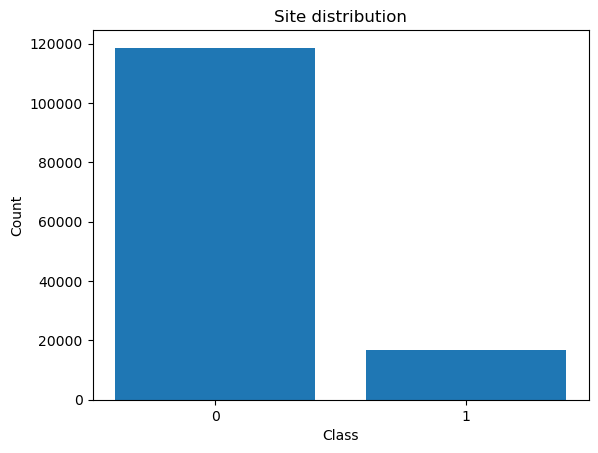

In [4]:
train_df["label"].unique() # Только значения 0 и 1
distribution_stats = train_df["label"].value_counts()
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Site distribution")
plt.bar(x=['0', '1'], height=distribution_stats.values)
distribution_stats.values

**Микровывод:**
<br>
Из диаграммы видим, что в датасете большой перекос в сторону не порнографических сайтов. Очевидно, что нужно обучать модель на сбалансированной выборке

## 2.2 Воспользуемся простым решением с TfidfVectorizer, применив эмбеддинг только к одной фиче

In [5]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

train_df = train_df.dropna()

tfidf_vectorizer = TfidfVectorizer()
num_features = tfidf_vectorizer.fit_transform(train_df['title'])

x_train, x_valid, y_train, y_valid = train_test_split(num_features, train_df["label"], test_size=0.25)

model = LogisticRegression()
model.fit(x_train, y_train)
print(classification_report(y_valid, model.predict(x_valid)))
print(confusion_matrix(y_valid, model.predict(x_valid)))

y_pred = model.predict(tfidf_vectorizer.transform(test_df['title']))
test_df["label"] = y_pred
test_df[["ID", "label"]].to_csv("ml_baseline.csv", index=False) # score 0.9142504626773597

              precision    recall  f1-score   support

           0       0.97      1.00      0.99     29563
           1       0.99      0.81      0.89      4264

    accuracy                           0.98     33827
   macro avg       0.98      0.91      0.94     33827
weighted avg       0.98      0.98      0.97     33827

[[29543    20]
 [  806  3458]]


**Микровывод:**
<br>
Score модели 9142504626773597. Модель показала хороший результат, но виден перекос в предсказаниях в сторону класса 0. Чтобы это исправить, попробуем сбалансировать по классам датасет


Обучаем модель на сбалансированной выборке

In [6]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

train_df = train_df.dropna()

tfidf_vectorizer = TfidfVectorizer()
num_features = tfidf_vectorizer.fit_transform(train_df['title'])

x_train, x_valid, y_train, y_valid = train_test_split(num_features, train_df["label"], test_size=0.25)

model = LogisticRegression(class_weight='balanced')
model.fit(x_train, y_train)
print(classification_report(y_valid, model.predict(x_valid)))
print(confusion_matrix(y_valid, model.predict(x_valid)))

y_pred = model.predict(tfidf_vectorizer.transform(test_df['title']))
test_df["label"] = y_pred
test_df[["ID", "label"]].to_csv("ml_baseline.csv", index=False) # score 0.9438922204879652

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     29676
           1       0.96      0.93      0.95      4151

    accuracy                           0.99     33827
   macro avg       0.98      0.96      0.97     33827
weighted avg       0.99      0.99      0.99     33827

[[29518   158]
 [  279  3872]]


**Микровывод:**
<br>
Score модели 0.9438922204879652. Видно, что количество ошибок по классам +- уравнялось, результат модели также улучшился

Проверим также работу модели по фиче url

In [7]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

train_df = train_df.dropna()

tfidf_vectorizer = TfidfVectorizer()
url_features = tfidf_vectorizer.fit_transform(train_df['url'])

x_train, x_valid, y_train, y_valid = train_test_split(url_features, train_df["label"], test_size=0.25)

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(x_train, y_train)
print(classification_report(y_valid, model.predict(x_valid)))
print(confusion_matrix(y_valid, model.predict(x_valid)))

y_pred = model.predict(tfidf_vectorizer.transform(test_df['url']))
test_df["label"] = y_pred
test_df[["ID", "label"]].to_csv("ml_baseline.csv", index=False) # score 0.8335864612714254

              precision    recall  f1-score   support

           0       0.99      0.96      0.97     29673
           1       0.76      0.94      0.84      4154

    accuracy                           0.96     33827
   macro avg       0.88      0.95      0.91     33827
weighted avg       0.96      0.96      0.96     33827

[[28465  1208]
 [  256  3898]]


**Микровывод:**
<br>
Score модели 0.8335864612714254. Результат сильно упал, значит, фича url менее информативная в сравнении с title
 

## 2.3 Попробуем теперь построить модель, используя оба категориальных признака

В данном решении отдельно ставим в соответствие вектор для url и title. Далее эти вектора стекируем

In [8]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

train_df = train_df.dropna()

tfidf_vectorizer1 = TfidfVectorizer()
tfidf_vectorizer2 = TfidfVectorizer()

title_features = tfidf_vectorizer1.fit_transform(train_df['title'])
url_features = tfidf_vectorizer2.fit_transform(train_df['url'])
combined_features = hstack([title_features, url_features])

x_train, x_valid, y_train, y_valid = train_test_split(combined_features, train_df["label"], test_size=0.25)

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(x_train, y_train)
print(classification_report(y_valid, model.predict(x_valid)))
print(confusion_matrix(y_valid, model.predict(x_valid)))

combined_test_result = hstack([tfidf_vectorizer1.transform(test_df['title']), tfidf_vectorizer2.transform(test_df['url'])])
y_pred = model.predict(combined_test_result)
test_df["label"] = y_pred
test_df[["ID", "label"]].to_csv("ml_baseline.csv", index=False) # score 0.9351205583756346

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29628
           1       0.98      0.96      0.97      4199

    accuracy                           0.99     33827
   macro avg       0.99      0.98      0.98     33827
weighted avg       0.99      0.99      0.99     33827

[[29541    87]
 [  147  4052]]


**Микровывод:**
<br>
Score модели 0.9351205583756346. Как видно из результата, стекирование эмбеддингов пользы не принесло. Скорее всего модель немного переобучилась из- за большого количества параметров

Теперь попробуем использовать эмбеддинг конкатенации строк из url и title

In [9]:
test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

train_df = train_df.dropna()

tfidf_vectorizer = TfidfVectorizer()
url_features = tfidf_vectorizer.fit_transform(train_df['title'] + train_df['url'])

x_train, x_valid, y_train, y_valid = train_test_split(url_features, train_df["label"], test_size=0.25)

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(x_train, y_train)
print(classification_report(y_valid, model.predict(x_valid)))
print(confusion_matrix(y_valid, model.predict(x_valid)))

y_pred = model.predict(tfidf_vectorizer.transform(test_df['title'] + test_df['url']))
test_df["label"] = y_pred
test_df[["ID", "label"]].to_csv("ml_baseline.csv", index=False) # score 0.9352861577648651

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     29617
           1       0.96      0.95      0.95      4210

    accuracy                           0.99     33827
   macro avg       0.98      0.97      0.97     33827
weighted avg       0.99      0.99      0.99     33827

[[29454   163]
 [  223  3987]]


**Микровывод:**
<br>
Score модели 0.9351205583756346. Результата также нет

## 3.1 Решенеи с использованием TfidfVectorizer для url и CountVectorizer для title

CountVectorizer - хорошее решение для title, т.к. title легко разбить на слова, а также можно выкинуть стоп-слова.
<br>
Для url оставим TfidfVectorizer
<br>
Также в данной функции в зависимости от параметра validation либо используется валидационная выборка с анализом результатов, либо нет

In [10]:
def predictPipeline(train_path, test_path, target, validation=False):
    transformer = ColumnTransformer([
        ("tfidf", TfidfVectorizer(), "url"),
        ("count", CountVectorizer(stop_words=stop_words), "title"),
    ])
    pipeline = Pipeline([
        ("preprocessor", transformer),
        ("model", LogisticRegression(class_weight='balanced', max_iter=1000))
    ])

    test_df = pd.read_csv(test_path)
    train_df = pd.read_csv(train_path)

    train_df = train_df.dropna()

    x_train = train_df
    y_train = train_df[target]
    del x_train[target]
    del x_train["ID"]

    if validation:
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25)

    pipeline.fit(x_train, y_train)
    predicts = pipeline.predict(test_df)

    if validation:
        validation_predicts = pipeline.predict(x_valid)
        print(classification_report(y_valid, validation_predicts))
        print(confusion_matrix(y_valid, validation_predicts))
        x_valid["true_label"] = y_valid
        x_valid["predicted_label"] = validation_predicts
        return x_valid

    test_df[target] = predicts
    test_df[["ID", target]].to_csv("ml_baseline.csv", index=False) # score 0.9573121246550884

predictPipeline("train.csv", "test.csv", "label")

**Микровывод:**
<br>
Score модели 0.9573121246550884. Видно, что использование CountVectorizer с учетом выброса стоп-слов улучшило результат

In [11]:
result_df = predictPipeline("train.csv", "test.csv", "label", validation=True)
incorrect_predictions = result_df[(result_df['true_label'] != result_df['predicted_label'])]
incorrect_predictions

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     29676
           1       0.94      0.96      0.95      4151

    accuracy                           0.99     33827
   macro avg       0.97      0.98      0.97     33827
weighted avg       0.99      0.99      0.99     33827

[[29436   240]
 [  157  3994]]


,url,title,true_label,predicted_label
849,folksland.net,Как грамотно расставить мебель в маленькой кух...,0,1
20405,surfthespear.com,Tristan Thompson thanks his fans | SurfTheSpea...,0,1
5986,antyseptyky.com,відсотків —,0,1
31697,arhles.net,Уголок,0,1
66069,m.xn----8sbp3abdbfk9f.com,"Рогоносец вылизал анус женушке, а та потрахала...",1,0
...,...,...,...,...
13662,gayrawclub.com,"Pierre Fitch Knock Out DF.AF,RG » Gay Raw Club",0,1
119541,video.brus.club,"MAINE MENDOZA, NAPAKALUHO RAW! MGA FANS TO THE...",0,1
102476,onlineporno.vip,Сама напросилась на реально жаркий и мощный ра...,1,0
114666,intsport.net,"Кубок остаётся без «Заречья». А может, и без «...",0,1


Попробуем отредактировать параметр url и сделать его более информативным.
<br>
Для этого оставим только доменное имя сайта, чтобы модель не искала лишних взаимосвязей.
<br>
<br>
Также подберем с помощью GridSearchCV оптимальные гиперпараметры

In [12]:
import tldextract

def extract_domain(url):
    return tldextract.extract(url).domain

def predictPipelineWithExtractedDomain(train_path, test_path, target, validation=False, find_best_params=False):
    transformer = ColumnTransformer([
        ("tfidf", TfidfVectorizer(min_df=1, max_df=0.5), "domain"),
        ("count", CountVectorizer(stop_words=stop_words), "title"),
    ])
    pipeline = Pipeline([
        ("preprocessor", transformer),
        ("model", LogisticRegression(class_weight='balanced', max_iter=1000))
    ])

    test_df = pd.read_csv(test_path)
    train_df = pd.read_csv(train_path)
    test_df['domain'] = test_df['url'].apply(extract_domain)
    train_df['domain'] = train_df['url'].apply(extract_domain)

    train_df = train_df.dropna()

    x_train = train_df
    y_train = train_df[target]
    del x_train[target]
    del x_train["ID"]

    if validation:
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25)


    if find_best_params:
        param_grid = {
            'preprocessor__tfidf__ngram_range': [(1, 3), (4, 6), (4, 8)],
            'preprocessor__tfidf__min_df': [1, 2, 4],
            'preprocessor__tfidf__max_df': [0.5, 0.7, 1.0]
        }
    
        grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
        grid_search.fit(x_train, y_train)

        print("Best parameters found on cross-validation set:")
        print(grid_search.best_params_)
        print("Best cross-validation score:")
        print(grid_search.best_score_)

    pipeline.fit(x_train, y_train)
    predicts = pipeline.predict(test_df)

    if validation:
        validation_predicts = pipeline.predict(x_valid)
        print(classification_report(y_valid, validation_predicts))
        print(confusion_matrix(y_valid, validation_predicts))
        x_valid["true_label"] = y_valid
        x_valid["predicted_label"] = validation_predicts
        return x_valid

    test_df[target] = predicts
    test_df[["ID", target]].to_csv("ml_baseline.csv", index=False) # score 0.9724997935419936

# predictPipelineWithExtractedDomain("train.csv", "test.csv", "label", find_best_params=True)
predictPipelineWithExtractedDomain("train.csv", "test.csv", "label")

**Микровывод:**
<br>
Score модели 0.9724997935419936. Для модели подобраны оптимальные гиперпараметры, также поле url стало более информативным для модели

Также попробуем вариант с кросс-валидацией. Будем использовать 15 фолдов и 15 моделей, соответственно. Результат возьмем как среднее работы всех моделей

In [13]:
def ensemble(X, y, x_res, fold_number: int = 2, model=LogisticRegression()):
    kf = KFold(n_splits=fold_number, shuffle=True, random_state=42)
    a = []
    for train_index, test_index in kf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        probabilities = model.predict_proba(x_res)
        a.append(probabilities)
    y_pred = (np.mean(a, axis=0)[:, 1] > 0.5).astype(int)
    return y_pred


transformer = ColumnTransformer([
    ("tfidf", TfidfVectorizer(), "url"),
    ("count", CountVectorizer(stop_words=stop_words), "title"),
])
pipeline = Pipeline([
    ("preprocessor", transformer),
    ("model", LogisticRegression(class_weight='balanced', max_iter=1000))
])

test_df = pd.read_csv("test.csv")
train_df = pd.read_csv("train.csv")

train_df = train_df.dropna()

x_train = train_df
y_train = train_df["label"]
del x_train["label"]
del x_train["ID"]

y_pred = ensemble(x_train, y_train, test_df, 25, pipeline)

test_df["label"] = y_pred
test_df[["ID", "label"]].to_csv("ml_baseline.csv", index=False) # score 0.9569875020288914

**Микровывод:**
<br>
Score модели 0.9569875020288914. Данный способ результата не принес, из этого можно сделать вывод, что модели обучаются +- одинаково и никак не дополняют друг друга


Попробуем использовать более точную реализацию логистической регрессии CatBoostClassifier

In [14]:
def extract_domain(url):
    return tldextract.extract(url).domain

def predictPipelineWithExtractedDomain(train_path, test_path, target, validation=False, find_best_params=False):
    transformer = ColumnTransformer([
        ("tfidf", TfidfVectorizer(min_df=1, max_df=0.5), "domain"),
        ("count", CountVectorizer(stop_words=stop_words), "title"),
    ])
    

    test_df = pd.read_csv(test_path)
    train_df = pd.read_csv(train_path)
    test_df['domain'] = test_df['url'].apply(extract_domain)
    train_df['domain'] = train_df['url'].apply(extract_domain)

    train_df = train_df.dropna()

    x_train = train_df
    y_train = train_df[target]
    del x_train[target]
    del x_train["ID"]

    weights = compute_class_weight(class_weight='balanced', classes=[0, 1], y=y_train)
    class_weights = dict(zip([0, 1], weights))

    pipeline = Pipeline([
        ("preprocessor", transformer),
        ("model", CatBoostClassifier(class_weights=class_weights, iterations=1000))
    ])

    if validation:
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25)


    if find_best_params:
        param_grid = {
            'preprocessor__tfidf__ngram_range': [(1, 3), (4, 6), (4, 8)],
            'preprocessor__tfidf__min_df': [1, 2, 4],
            'preprocessor__tfidf__max_df': [0.5, 0.7, 1.0]
        }
    
        grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
        grid_search.fit(x_train, y_train)

        print("Best parameters found on cross-validation set:")
        print(grid_search.best_params_)
        print("Best cross-validation score:")
        print(grid_search.best_score_)

    pipeline.fit(x_train, y_train)
    predicts = pipeline.predict(test_df)

    if validation:
        validation_predicts = pipeline.predict(x_valid)
        print(classification_report(y_valid, validation_predicts))
        print(confusion_matrix(y_valid, validation_predicts))
        x_valid["true_label"] = y_valid
        x_valid["predicted_label"] = validation_predicts
        return x_valid

    test_df[target] = predicts
    test_df[["ID", target]].to_csv("ml_baseline.csv", index=False) # score 0.9626915389740173

# predictPipelineWithExtractedDomain("train.csv", "test.csv", "label", find_best_params=True)
predictPipelineWithExtractedDomain("train.csv", "test.csv", "label")

Learning rate set to 0.083755
0:	learn: 0.6027330	total: 576ms	remaining: 9m 35s
1:	learn: 0.5390817	total: 950ms	remaining: 7m 53s
2:	learn: 0.4999958	total: 1.32s	remaining: 7m 17s
3:	learn: 0.4718684	total: 1.7s	remaining: 7m 2s
4:	learn: 0.4501716	total: 2.1s	remaining: 6m 57s
5:	learn: 0.4343968	total: 2.46s	remaining: 6m 47s
6:	learn: 0.4162229	total: 2.83s	remaining: 6m 40s
7:	learn: 0.4028474	total: 3.19s	remaining: 6m 35s
8:	learn: 0.3931730	total: 3.57s	remaining: 6m 33s
9:	learn: 0.3828974	total: 3.94s	remaining: 6m 30s
10:	learn: 0.3752000	total: 4.31s	remaining: 6m 27s
11:	learn: 0.3667644	total: 4.68s	remaining: 6m 25s
12:	learn: 0.3594311	total: 5.05s	remaining: 6m 23s
13:	learn: 0.3525812	total: 5.42s	remaining: 6m 21s
14:	learn: 0.3450572	total: 5.79s	remaining: 6m 19s
15:	learn: 0.3396238	total: 6.15s	remaining: 6m 18s
16:	learn: 0.3343562	total: 6.53s	remaining: 6m 17s
17:	learn: 0.3294110	total: 6.89s	remaining: 6m 16s
18:	learn: 0.3238883	total: 7.25s	remaining: 6m

**Микровывод:**
<br>
Score модели 0.9626915389740173. Результат несколько упал

Теперь попробуем добавить функцию для создания характерных слов для каждого класса, будем использовать их для постобработки

In [15]:
def findTopValuableWords(df, target, class_number, count=5):
    tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words, lowercase=True, token_pattern=r'\b[^\d\W]+\b')
    tfidf_matrix = tfidf_vectorizer.fit_transform(df[df[target] == class_number]["title"])

    feature_names = tfidf_vectorizer.get_feature_names_out()
    top_indices = tfidf_matrix.mean(axis=0).argsort()[:, -count:].flatten()

    top_words = [feature_names[idx] for idx in top_indices]

    return top_words

train_df = pd.read_csv("train.csv")
train_df = train_df.dropna()

class1_triggers = set(findTopValuableWords(train_df, "label", 1, 600)[0][0]) - \
    set(findTopValuableWords(train_df, "label", 0, 3500)[0][0])

class1_free_triggers = set([
    
])

Используем модель и после обрабатываем результаты

In [16]:
def extract_domain(url):
    return tldextract.extract(url).domain

def predictPipelineWithExtractedDomain(train_path, test_path, target, validation=False, find_best_params=False):
    transformer = ColumnTransformer([
        ("tfidf", TfidfVectorizer(analyzer="char_wb", min_df=4, max_df=0.5, ngram_range=(2, 4)), "domain"),
        ("count", CountVectorizer(stop_words=stop_words), "title"),
    ])
    pipeline = Pipeline([
        ("preprocessor", transformer),
        ("model", LogisticRegression(class_weight='balanced', max_iter=1000, solver='lbfgs'))
    ])

    test_df = pd.read_csv(test_path)
    train_df = pd.read_csv(train_path)
    test_df['domain'] = test_df['url'].apply(extract_domain)
    train_df['domain'] = train_df['url'].apply(extract_domain)

    train_df = train_df.dropna()

    x_train = train_df
    y_train = train_df[target]
    del x_train[target]
    del x_train["ID"]
    test_df['title'] = test_df['title'].astype(str)

    if validation:
        x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.25)


    if find_best_params:
        param_grid = {
            'preprocessor__tfidf__ngram_range': [(2, 4), (4, 6), (4, 8)],
            'preprocessor__tfidf__min_df': [1, 2, 4],
            'preprocessor__tfidf__max_df': [0.5, 0.7, 1.0]
        }
    
        grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
        grid_search.fit(x_train, y_train)

        print("Best parameters found on cross-validation set:")
        print(grid_search.best_params_)
        print("Best cross-validation score:")
        print(grid_search.best_score_)

    pipeline.fit(x_train, y_train)
    predicts = pipeline.predict(test_df)

    if validation:
        validation_predicts = pipeline.predict(x_valid)
        print(classification_report(y_valid, validation_predicts))
        print(confusion_matrix(y_valid, validation_predicts))
        x_valid["true_label"] = y_valid
        x_valid["predicted_label"] = validation_predicts
        return x_valid
    
    # Постобработка
    for idx, _ in enumerate(predicts):
        title = x_test["title"].iloc[idx]
        url = x_test["url"].iloc[idx]
        if isinstance(title, str):
            title = title.lower()

            for word in (class1_triggers + class1_free_triggers):
                if word in title:
                    predicts[idx] = 1

    test_df[target] = predicts
    test_df[["ID", target]].to_csv("ml_baseline.csv", index=False) # score 0.9802919106126824

predictPipelineWithExtractedDomain("train.csv", "test.csv", "label", find_best_params=False)

**Микровывод:**
<br>
Score модели 0.9802919106126824. Результат немного увеличился, но сильного прироста это не дало

## Вывод

В итоговой модели было использовано (то, что принесло улучшение результат):
1) Балансировка данных по классам;
2) Подготовка фичи url;
3) Использование TfidfVectorizer с оптимальными гиперпараметрами для url;
4) Использование CountVectorizer с библиотечными стоп-словами;
5) С помощью GridSearchCV были найдены лучшие гиперпараметры для модели;
6) Был написан алгоритм постобработки на основе слов-триггеров